In [1]:
# modified from test.ipynb and main.py

from matplotlib import pyplot as plt
import numpy as np
import GPy

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(level=logging.INFO)

from emukit.model_wrappers import GPyModelWrapper
from emukit.model_wrappers.gpy_quadrature_wrappers import BaseGaussianProcessGPy, RBFGPy

from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.core.loop import UserFunctionWrapper

from emukit.core import ParameterSpace, ContinuousParameter
from emukit.core.initial_designs import RandomDesign

from GPy.models import GPRegression

from skopt.benchmarks import branin as _branin
from emukit.test_functions import branin_function

from scse.api.simulation import run_simulation

from matplotlib.colors import LogNorm
from matplotlib import pyplot as plt

# Decision loops 
from emukit.experimental_design import ExperimentalDesignLoop
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
from emukit.quadrature.loop import VanillaBayesianQuadratureLoop

# Acquisition functions 
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement
from emukit.experimental_design.acquisitions import ModelVariance
# from emukit.quadrature.acquisitions import IntegralVarianceReduction
from emukit.experimental_design.acquisitions import IntegratedVarianceReduction

# Acquistion optimizers
from emukit.core.optimization import GradientAcquisitionOptimizer

# Stopping conditions
from emukit.core.loop import FixedIterationsStoppingCondition
from emukit.core.loop import ConvergenceStoppingCondition

from emukit.bayesian_optimization.acquisitions.log_acquisition import LogAcquisition

In [2]:
from loop import *

In [3]:
max_num_batteries = 25
num_batteries = DiscreteParameter(
    'num_batteries', [i for i in range(0, max_num_batteries)])
week = 336
time_horizon = DiscreteParameter(
    'time_horizon', [i for i in range(0, 52*week, week)])
parameter_space = ParameterSpace([num_batteries])
design = RandomDesign(parameter_space)

In [4]:
battery_penalty = 500
def f(X):
    """
    Handling API call to miniSCOT simulation given some inputs

    X contains parameter configs x = [x0 x1 ...]
    - The order of parameters in x should follow the order specified in the parameter_space declaration
    - E.g. here we specify num_batteries = x[0]

    """
    Y = []
    for x in X:
        num_batteries = x[0]

        cum_reward = run_simulation(
            time_horizon=336, num_batteries=num_batteries,battery_penalty=battery_penalty)

        Y.append(-cum_reward[-1])

    Y = np.reshape(np.array(Y), (-1, 1))
    return Y

In [8]:
# Initial set of batteries and associated reward of simulation
num_data_points = 2
X = design.get_samples(num_data_points)
Y = f(X)


In [9]:
# emulator model
use_default= False
if use_default: 
    gpy_model = GPRegression(X, Y)
else: 
    kernel = GPy.kern.RBF(1, lengthscale=1e1, variance=1e4, ARD=False)
    gpy_model = GPy.models.GPRegression(X, Y, kernel, noise_var=1e-10)
gpy_model.optimize()
model_emukit = GPyModelWrapper(gpy_model)

In [10]:
X, Y


(array([[18],
        [ 6]]),
 array([[  80825],
        [1095430]]))

In [11]:
# Load core elements for Bayesian optimization
expected_improvement = ExpectedImprovement(model=model_emukit)
optimizer = GradientAcquisitionOptimizer(space=parameter_space)

In [12]:
# Create the Bayesian optimization object
batch_size = 3
bayesopt_loop = BayesianOptimizationLoop(model=model_emukit,
                                         space=parameter_space,
                                         acquisition=expected_improvement,
                                         batch_size=batch_size)


In [13]:
# Run the loop and extract the optimum;  we either complete 10 steps or converge
max_iters = 10
stopping_condition = FixedIterationsStoppingCondition(
    i_max=max_iters) | ConvergenceStoppingCondition(eps=0.01)

bayesopt_loop.run_loop(f, stopping_condition)

In [14]:
# Visualize and get extrema
new_X, new_Y = bayesopt_loop.loop_state.X, bayesopt_loop.loop_state.Y

In [15]:
print(new_X, new_X.shape)
order = new_X.argsort(axis=0)
print(new_X[order])

[[18.]
 [ 6.]
 [ 5.]
 [10.]
 [ 2.]
 [ 8.]
 [13.]
 [20.]
 [24.]
 [24.]
 [24.]] (11, 1)
[[[ 2.]]

 [[ 5.]]

 [[ 6.]]

 [[ 8.]]

 [[10.]]

 [[13.]]

 [[18.]]

 [[20.]]

 [[24.]]

 [[24.]]

 [[24.]]]


In [16]:
new_X = new_X[order].flatten().reshape(-1, 1)
new_Y = new_Y[order].flatten().reshape(-1, 1)

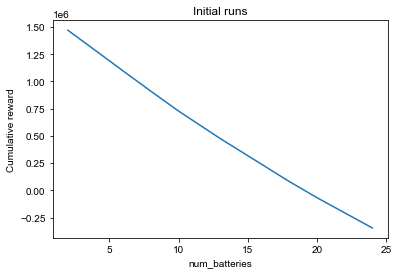

In [17]:
plt.plot(new_X, new_Y)
plt.style.use('seaborn')
plt.title("Initial runs")
plt.xlabel(parameter_space.parameters[0].name)
plt.ylabel("Cumulative reward")
plt.show()

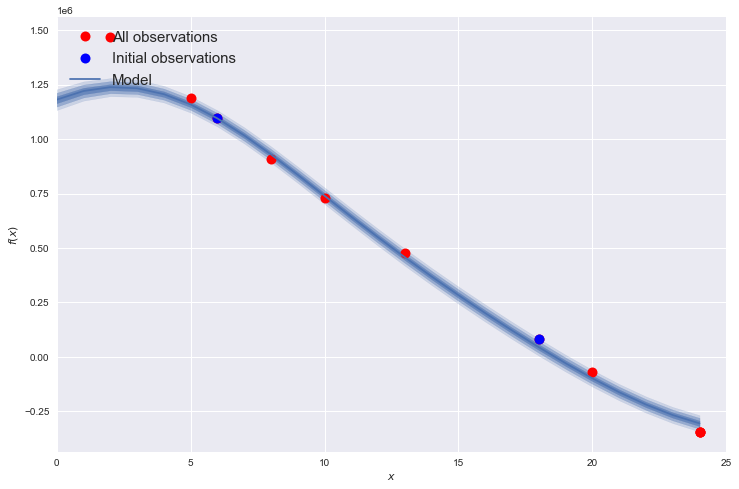

In [18]:
x_plot = np.reshape(np.array([i for i in range(0, 25)]), (-1,1))
mu_plot, var_plot = model_emukit.predict(x_plot)

plt.figure(figsize=(12, 8))
LEGEND_SIZE = 15
plt.plot(new_X, new_Y, "ro", markersize=10, label="All observations")
plt.plot(X, Y, "bo", markersize=10, label="Initial observations")
# plt.plot(x_plot, y_plot, "k", label="Objective Function")
plt.plot(x_plot, mu_plot, "C0", label="Model")
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color="C0", alpha=0.6)
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.4)
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 3 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 3 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.2)

plt.legend(loc=2, prop={'size': LEGEND_SIZE})
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.grid(True)
plt.xlim(0, 25)
plt.show()